In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader

In [70]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/zero-shot'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import create_sliding_windows, SequentialDeepONetDataset
from helper import load_model_experiment, convert2dim, train_val_test_split, plot_global_field_cartopy, plot_global_field_box

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [71]:
#------------------------------
# Load model
#------------------------------
model_path = 'single_branch/lstm_window_30.pth'

model = load_model_experiment(model_path).to(device)

print(model)

Loaded model from single_branch/lstm_window_30.pth
SequentialDeepONet(
  (branch_net): LSTM(
    (lstm): LSTM(12, 128, num_layers=4, batch_first=True)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=128, out_features=128, bias=True)
  )
  (trunk_net): FCN(
    (network): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)


/projects/bcnx/kazumak2/CosmicRays-Operator/analysis/zero-shot/helper.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [72]:
#------------------------------
# Load test input function (unseen 2023 data)
# Load test target (resolution 1 deg)
#------------------------------
input_sensor = np.load('data/neutron_data_22yrs.npy')

# 1 degree target (scaled)
output_1deg = np.load('data/dose_array.npy')

In [73]:
# data splitting keeping the consistency with training phase
train_input, train_target, val_input, val_target, test_input, test_target = train_val_test_split(input_sensor, output_1deg)

Train input shape: (4017, 12)
Validation input shape: (4018, 12)
Test input shape: (365, 12)


In [74]:
# input scaler
scaler = MinMaxScaler()

dummy = scaler.fit_transform(train_input)
test_input = scaler.transform(test_input)

# target data normalization (min-max scaling)
scaler_target = MinMaxScaler()
train_target = scaler_target.fit_transform(train_target)[..., np.newaxis]
test_target = scaler_target.transform(test_target)[..., np.newaxis]

In [75]:
# location points for 1 degree target
trunk_1deg = np.load('data/grid_points.npy')

print('location range (1 deg):', np.min(trunk_1deg[:,0]), np.max(trunk_1deg[:,0]), np.min(trunk_1deg[:,1]), np.max(trunk_1deg[:,1]))

# Normalize trunk input
trunk_1deg[:, 0] = (trunk_1deg[:, 0] - np.min(trunk_1deg[:, 0])) / (np.max(trunk_1deg[:, 0]) - np.min(trunk_1deg[:, 0]))
trunk_1deg[:, 1] = (trunk_1deg[:, 1] - np.min(trunk_1deg[:, 1])) / (np.max(trunk_1deg[:, 1]) - np.min(trunk_1deg[:, 1]))

location range (1 deg): -90.0 90.0 -180.0 180.0


In [76]:
# Generate sequences for the testing set
test_input_seq, test_target_seq = create_sliding_windows(test_input, test_target, window_size=30)
print('test_input_seq shape:', test_input_seq.shape)
print('test_target_seq shape:', test_target_seq.shape)

test_input_seq shape: torch.Size([336, 30, 12])
test_target_seq shape: torch.Size([336, 65341, 1])


In [77]:
# Create DataLoader for test set
test_dataset = SequentialDeepONetDataset(test_input_seq, trunk_1deg, test_target_seq)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [78]:
def fit(model, data_loader, device):
    all_outputs = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for branch_batch, trunk_batch, target_batch in data_loader:
            branch_batch, trunk_batch, target_batch = (
                branch_batch.to(device),
                trunk_batch.to(device),
                target_batch.to(device),
            )
            output = model(branch_batch, trunk_batch)
            
            all_outputs.append(output.cpu())
            all_targets.append(target_batch.cpu())

    # ...existing code...
    # After loop:
    outputs = torch.cat(all_outputs, dim=0)  # [N_test, ...]
    targets = torch.cat(all_targets, dim=0)  # [N_test, ...]

    # move to numpy
    outputs = outputs.cpu().numpy()
    targets = targets.cpu().numpy()

    # flatten to 2D (n_samples, n_features) for scaler
    out_shape = outputs.shape
    tgt_shape = targets.shape
    outputs_flat = outputs.reshape(outputs.shape[0], -1)
    targets_flat = targets.reshape(targets.shape[0], -1)

    # inverse scale
    outputs_flat = scaler_target.inverse_transform(outputs_flat)
    targets_flat = scaler_target.inverse_transform(targets_flat)

    # restore original shapes
    outputs = outputs_flat.reshape(out_shape)
    targets = targets_flat.reshape(tgt_shape)
    # ...existing code...

    
    return outputs, targets

In [79]:
predictions_1deg, targets_1deg = fit(model, test_loader, device)
print('predictions shape:', predictions_1deg.shape)
print('targets shape:', targets_1deg.shape)

predictions shape: (336, 65341, 1)
targets shape: (336, 65341, 1)


In [80]:
lon_grid, lat_grid, pred_img = convert2dim(predictions_1deg)  # (N,H,W)
_,        _,        targ_img = convert2dim(targets_1deg)      # (N,H,W)

In [81]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

pred_img = pred_img.astype(np.float64)
targ_img = targ_img.astype(np.float64)

N = pred_img.shape[0]
eps = 1e-12

# ---- Relative L2 (%) per-sample + mean ----
pf = pred_img.reshape(N, -1)
tf = targ_img.reshape(N, -1)
rel_l2 = np.linalg.norm(pf - tf, axis=1) / np.maximum(np.linalg.norm(tf, axis=1), eps)
rel_l2_pct = 100.0 * rel_l2
print("Mean rel L2 (%):", rel_l2_pct.mean())

# (optional) global relative L2 (%)
global_rel_l2_pct = 100.0 * np.linalg.norm(pf - tf) / (np.linalg.norm(tf) + eps)
print("Global rel L2 (%):", global_rel_l2_pct)

# ---- SSIM per-sample + mean (uses target’s per-sample dynamic range) ----
ssim_scores = np.empty(N, dtype=float)
for i in range(N):
    dr = float(targ_img[i].max() - targ_img[i].min()) or 1.0
    ssim_scores[i] = ssim(targ_img[i], pred_img[i], data_range=dr)
print("Mean SSIM:", ssim_scores.mean())

Mean rel L2 (%): 0.11222334735855127
Global rel L2 (%): 0.11618928691362994
Mean SSIM: 0.9993264089659769


In [82]:
from skimage.filters import sobel

def gradient_magnitude_similarity(pred, targ):
    gx_p, gy_p = np.gradient(pred)
    gx_t, gy_t = np.gradient(targ)
    gm_p = np.sqrt(gx_p**2 + gy_p**2)
    gm_t = np.sqrt(gx_t**2 + gy_t**2)
    numerator = 2 * gm_p * gm_t + 1e-8
    denominator = gm_p**2 + gm_t**2 + 1e-8
    return np.mean(numerator / denominator)

# Example per-sample
gmsd_scores = np.array([gradient_magnitude_similarity(pred_img[i], targ_img[i]) for i in range(N)])
print("Mean Gradient Similarity:", gmsd_scores.mean())


Mean Gradient Similarity: 0.9990863294344242


In [83]:
def high_freq_energy_ratio(pred, targ, frac=0.2):
    Fp = np.fft.fftshift(np.abs(np.fft.fft2(pred)))
    Ft = np.fft.fftshift(np.abs(np.fft.fft2(targ)))
    h, w = Fp.shape
    cy, cx = h // 2, w // 2
    r = int(frac * min(cy, cx))
    yy, xx = np.ogrid[:h, :w]
    mask = (yy - cy)**2 + (xx - cx)**2 >= r**2
    return (Fp[mask].sum() / Ft[mask].sum())

hf_ratios = np.array([high_freq_energy_ratio(pred_img[i], targ_img[i]) for i in range(N)])
print("Mean High-Frequency Energy Ratio:", hf_ratios.mean())


Mean High-Frequency Energy Ratio: 1.007583966650806


In [84]:
from scipy.ndimage import laplace

def edge_preservation(pred, targ):
    Lp = laplace(pred)
    Lt = laplace(targ)
    return np.corrcoef(Lp.flatten(), Lt.flatten())[0,1]

epi_scores = np.array([edge_preservation(pred_img[i], targ_img[i]) for i in range(N)])
print("Mean Edge Preservation Index:", epi_scores.mean())


Mean Edge Preservation Index: 0.9978208517809299


In [85]:
import pandas as pd

def make_sequence_windows(year: int, seq_len: int = 30, leap: bool = True):
    """
    Create sequence window metadata for EXPACS daily data,
    where target_date == end_date (same-day prediction).

    Parameters
    ----------
    year : int
        Target simulation year (e.g., 2023)
    seq_len : int, optional
        Number of days per input sequence (default: 30)
    leap : bool, optional
        Whether to include Feb 29 in leap years (default: True)

    Returns
    -------
    windows : pd.DataFrame
        Columns:
          - 'start_date': first day of input sequence
          - 'end_date': last day of input sequence (== target)
          - 'target_date': same as end_date
          - 'index': sequential integer index (0, 1, 2, …)
    """

    # Determine number of days in this year
    n_days = 366 if (leap and pd.Timestamp(year=year, month=12, day=31).is_leap_year) else 365

    # Build full daily timeline
    dates = pd.date_range(f"{year}-01-01", periods=n_days, freq="D")

    start_dates, end_dates, target_dates = [], [], []

    # Sliding windows
    for i in range(seq_len - 1, n_days):
        start_dates.append(dates[i - seq_len + 1])
        end_dates.append(dates[i])
        target_dates.append(dates[i])   # same as end_date

    df = pd.DataFrame({
        "index": range(len(target_dates)),
        "start_date": start_dates,
        "end_date": end_dates,
        "target_date": target_dates
    })

    return df


# =============================
# Example usage
# =============================
year = 2023
seq_len = 30
meta = make_sequence_windows(year, seq_len)

print(meta.head(5))
print(f"\nTotal windows: {len(meta)}")


   index start_date   end_date target_date
0      0 2023-01-01 2023-01-30  2023-01-30
1      1 2023-01-02 2023-01-31  2023-01-31
2      2 2023-01-03 2023-02-01  2023-02-01
3      3 2023-01-04 2023-02-02  2023-02-02
4      4 2023-01-05 2023-02-03  2023-02-03

Total windows: 336


In [86]:
year = 2023
seq_len = 30
meta = make_sequence_windows(year, seq_len)

print(meta.head())

target_date = meta['target_date'].to_numpy()

   index start_date   end_date target_date
0      0 2023-01-01 2023-01-30  2023-01-30
1      1 2023-01-02 2023-01-31  2023-01-31
2      2 2023-01-03 2023-02-01  2023-02-01
3      3 2023-01-04 2023-02-02  2023-02-02
4      4 2023-01-05 2023-02-03  2023-02-03


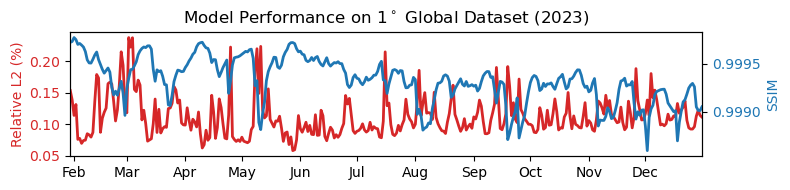

In [87]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, 1, figsize=(8, 2))

# Plot rel L2 (%) on first y-axis
color1 = 'tab:red'
#ax.set_xlabel('Target Date')
ax.set_ylabel('Relative L2 (%)', color=color1)
ax.plot(target_date, rel_l2_pct, color=color1, linewidth=2, label='Rel L2 (%)')
ax.tick_params(axis='y', labelcolor=color1)
#ax.grid(True, alpha=0.3)
ax.set_xlim([target_date[0], target_date[-1]])

# Create second y-axis for SSIM
ax2 = ax.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('SSIM', color=color2)
ax2.plot(target_date, ssim_scores, color=color2, linewidth=2, label='SSIM')
ax2.tick_params(axis='y', labelcolor=color2)

# Format x-axis to show only months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Add title
plt.title(f'Model Performance on $1^\\circ$ Global Dataset ({year})')

plt.tight_layout()
plt.show()